In [1]:
from cpw_lib import *
import gdstk

# Making CPW resonator GDS design

In [2]:
x0 = 300
y0 = 0
feed = CPWFeedline(start=(0+x0, 0+y0), end=(0+x0, 1000+y0),
                       w=30, g=4, launchpad=None)

reson = CPWResonator(length=2350, w=70, g=30, f=10,
                         start=(174+x0, 350+y0), orientation="right",
                         coupling_arm=True, arm_length=150, arm_dir="down",
                         termination="open")

feed_center, feed_gap = feed.geometry()
res_center,  res_gap  = reson.geometry()

    # ----- assemble GDS ---------------------------------------------------
lib  = gdstk.Library(unit=1e-6, precision=1e-9)  # µm units
cell = lib.new_cell("CPW_DEMO")

    # layer 1: metal
metal_union = so.unary_union([feed_center, res_center])
for poly in metal_union.geoms if hasattr(metal_union, "geoms") else [metal_union]:
    cell.add(gdstk.Polygon(poly.exterior.coords, layer=1))

# layer 2: gap / etch
gap_union = so.unary_union([feed_gap, res_gap])
for poly in gap_union.geoms if hasattr(gap_union, "geoms") else [gap_union]:
    cell.add(gdstk.Polygon(poly.exterior.coords, layer=2))

In [3]:
lib  = gdstk.Library(unit=1e-6, precision=1e-9)
cell = lib.new_cell("CPW_DEMO")
# layer 1 – centre conductors
metal  = so.unary_union([feed_center, res_center])
#for p in _to_gdstk_list(metal, layer=1):
#    cell.add(p)

# layer 2 – etched gaps
gaps   = so.unary_union([feed_gap,    res_gap])
#for p in _to_gdstk_list(gaps, layer=2):
#    cell.add(p)

# -------- ground plane with hollowed-out gaps (layer 3) ---------
margin = 200           # µm extra round the bounding box
minx, miny, maxx, maxy = so.unary_union([metal, gaps]).bounds
#rect_shp = sg.box(minx - margin, miny - margin, maxx + margin, maxy + margin)
rect_shp = sg.box(minx - margin, miny, maxx + margin, maxy)

# Boolean subtraction in gdstk (works for 0.9.x)
rect_poly = gdstk.Polygon(list(rect_shp.exterior.coords))
gap_list  = to_gdstk_list(gaps, layer=3)
ground_polys = gdstk.boolean([rect_poly], gap_list, "not", layer=3)

for gp in ground_polys:
    cell.add(gp)

lib.write_gds("cpw_demo.gds")
print("Wrote cpw_demo.gds  (layer 3 = ground with hollow gaps)")


Wrote cpw_demo.gds  (layer 3 = ground with hollow gaps)


# Configure Sonnect Project Setting

In [4]:
import logging
import numpy as np
import pysonnet as ps
# gdspy is available via 'pip install gdspy'
# or at https://github.com/heitzmann/gdspy
#import gdspy as gp

sonnet_file_path = r"C:/Users/slab/Desktop/Yueheng_Sonnet/cpw_res_demo/cpw.son"
path_to_sonnet = r"C:/Program Files/Sonnet Software/18.56/"

# Set up logging to the console
log = logging.getLogger()
log.setLevel(logging.INFO) # Only prints project.run() information. Set to logging.DEBUG for more detail
log.addHandler(logging.StreamHandler())

In [5]:
box_x = 3100
box_y = 1000
layer = 0
datatype = 0
# The GeometryProject is the most basic Sonnet project type
project = ps.GeometryProject()

# The default length unit for Sonnet is mils,so let's change it
project.set_units(length='um')

# Then we can set up the box
project.setup_box(box_x, box_y, 2000, 2000)

# Define the metal types and if they are on the box top/bottom
# high kinetic inductance superconductor
project.define_metal("general", "NbN", ls=35)
# low kinetic inductance superconductor
#project.define_metal("general", "Nb", ls=0.08)
project.set_box_cover("free space", top=True)
#project.set_box_cover("custom", name="Nb", bottom=True)

# Lets add a dielectric layer under the microstrip and air above
project.add_dielectric("air", layer, thickness=1000)
project.add_dielectric("silicon", layer + 1, thickness=100,
                       epsilon=11.7, dielectric_loss=0.0,
                       conductivity=0.0)

# We can also define technology layers
project.define_technology_layer("metal", "Superconductor", layer,
                                "NbN", fill_type="staircase",x_min = 1,x_max = 100,y_min=1,y_max = 100)

# We also might want to see the current density
project.set_options(current_density=True,q_accuracy=True,resonance_detection=True)
#project.set_options(q_accuracy=True)
#project.set_options(resonance_detection=True)
#project.set_options(frequency_cache=True)

# Load Geometry into Pysonnet

In [6]:
project.add_gdstk_cell(polygon_type='metal',cell=cell,tech_layer='Superconductor')

In [7]:
project.add_port("standard", 1, x0, 1000,  resistance=50)

number of ports:  0

1 5 -1 N 0 1 1 100 100 0 0 0 Y

TLAYNAM "Superconductor" INH
81.00000000 1000.00000000
81.00000000 0.00000000
281.00000000 0.00000000
281.00000000 1000.00000000
81.00000000 1000.00000000
tokens= ['1', '5', '-1', 'N', '0', '1', '1', '100', '100', '0', '0', '0', 'Y']
file_id: []
len of blks:  3
lines 1 5 -1 N 30 1 1 100 100 0 0 0 Y


In [8]:
project.add_port("standard", 2, x0, 0,  resistance=50)

number of ports:  1

1 5 -1 N 0 1 1 100 100 0 0 0 Y

TLAYNAM "Superconductor" INH
81.00000000 1000.00000000
81.00000000 0.00000000
281.00000000 0.00000000
281.00000000 1000.00000000
81.00000000 1000.00000000
tokens= ['1', '5', '-1', 'N', '30', '1', '1', '100', '100', '0', '0', '0', 'Y']
file_id: ['30']
len of blks:  3
lines 1 5 -1 N 30 1 1 100 100 0 0 0 Y


# Set up Sonnet Simulation

In [9]:
project.add_syz_parameter_file(
    file_type='touchstone',    # write a .sNp file
    file_name='cpw.s2p'       # name it test.s2p (default: $BASENAME.s2p)
)

In [10]:
# Add the frequency sweep to the project
#project.add_frequency_sweep("linear", f1=4.89, f2=4.90, n_points=51)
project.add_frequency_sweep("abs",f1=7.05,f2=7.1)
# Select an analysis (doesn't need to be done if running the project)
project.set_analysis("frequency sweep")
# Make the sonnet file
project.make_sonnet_file(sonnet_file_path)

In [11]:
project.locate_sonnet(path_to_sonnet)

Testing sonnet
ELECTROMAGNETIC ANALYSIS OF 3-D PLANAR CIRCUITS
Version 18.56
Copyright (c) 1986-2022 Sonnet Software Inc.
All rights reserved.
Run 1:  Fri Jun 13 16:38:09 2025.  uchicago4.1.85014.
Em version 18.56 (64-bit Windows) on ziqian-li-mem local.
Project:  C:\Users\slab\Desktop\Yueheng_Sonnet\cpw_res_demo\test.son.
Begin electromagnetic simulation using frequency sweep:
Single Frequency = 1 GHZ
Frequency:  1 GHZ
Subsectioning time:  0 seconds.
Circuit requires 1 subsection and 1 MB of memory.
Threads:  using 64 thread(s), 64 core(s) available.
Waveguide mode time:  0.003 seconds.
Matrix fill time:  0.022 seconds.
Matrix solve time:  0.025 seconds.
De-embedded S-Parameters. 50 Ohm Port Terminations.
Magnitude/Angle. Touchstone Format. Matrix Order (line #1: S11 S12 S13 ...).
1.00000000 1.000000 -0.260
! P1 F=1.0 Eeff=(1.00693 + j0) Z0=(152.57 + j0)
Total time per frequency:  0.163 seconds.
Post-Analysis information for em run 1:
Total time for 1 frequency:  0.187 seconds.
Em err

In [12]:
project.run("frequency sweep")

ELECTROMAGNETIC ANALYSIS OF 3-D PLANAR CIRCUITS
Version 18.56
Copyright (c) 1986-2022 Sonnet Software Inc.
All rights reserved.
Run 1:  Fri Jun 13 16:38:13 2025.  .
Em version 18.56 (64-bit Windows) on ziqian-li-mem local.
Project:  C:\Users\slab\Desktop\Yueheng_Sonnet\cpw_res_demo\cpw.son.
Begin electromagnetic simulation using frequency sweep:
ABS Start = 7.05, Stop = 7.1 GHZ
Frequency:  7.05 GHZ
Subsectioning time:  1 minute 29 seconds.
Circuit requires 8123 subsections and 1928 MB of memory.
Threads:  using 64 thread(s), 64 core(s) available.
Waveguide mode time:  0.157 seconds.
Matrix fill time:  1 minute 51 seconds.
Matrix solve time:  4 seconds.
De-embedded S-Parameters. 50 Ohm Port Terminations.
Magnitude/Angle. Touchstone Format. (S11 S21 S12 S22).
7.05000000 0.393282 34.779 0.919394 -54.94 0.919394 -54.94 0.393301 35.340
! P1 F=7.05 Eeff=(36.5738 - j0.00015607) Z0=(84.2926 - j0.000223217)
! P2 F=7.05 Eeff=(36.5738 - j0.00015607) Z0=(84.2926 - j0.000223217)
Total time per freq

In [3]:
# 3) Load the .s2p and plot S12
from pysonnet.outputs import SYZParameter
#import numpy as np
import matplotlib.pyplot as plt
import numpy as np

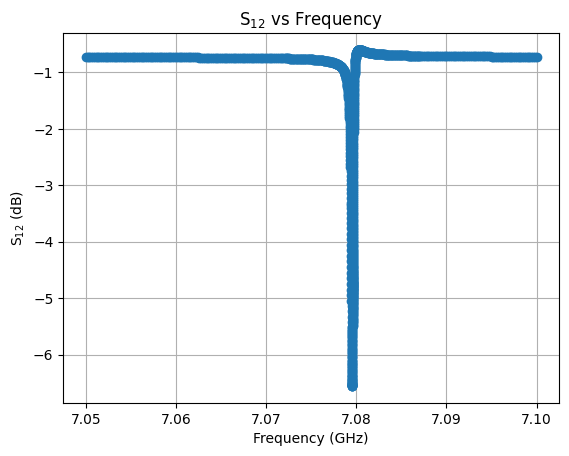

Plot saved to /Users/eesh/Documents/mcp_hackathon_2025/cqed-design-ai/fitting/fitting_server/plots/s21_plot.png


In [ ]:
from pysonnet.outputs import SYZParameter
import numpy as np
import os
import matplotlib.pyplot as plt




def plot_s21(file_path, plot_folder_path=None):
    import matplotlib.pyplot as plt

    # Read in the Touchstone file
    sp = SYZParameter.from_touchstone(file_path)

    # Extract frequencies (GHz) and the S-matrix
    f = sp.f  # shape (N,) in GHz
    S = sp.value  # shape (N, 2, 2)

    # Pick out S12 = measurement at port 1 due to excitation at port 2
    s12 = S[:, 0, 1]

    # Plot magnitude in dB
    fig = plt.figure()
    plt.plot(f, 20 * np.log10(np.abs(s12)), marker='o')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('S$_{12}$ (dB)')
    plt.title('S$_{12}$ vs Frequency')
    plt.grid(True)
    plt.show()

    if plot_folder_path:
        if not os.path.exists(plot_folder_path):
            os.makedirs(plot_folder_path)
        plot_path = os.path.join(plot_folder_path, "s21_plot.png")
        fig.savefig(plot_path)
        print(f"Plot saved to {plot_path}")
   
    



    return s12
file_path = '/Users/eesh/Documents/mcp_hackathon_2025/cqed-design-ai/fitting/cpw.s2p'
plot_folder = '/Users/eesh/Documents/mcp_hackathon_2025/cqed-design-ai/fitting/fitting_server/plots'
s12  = plot_s21(file_path, plot_folder_path=plot_folder)



In [ ]:
q_array = np.real(s12)
i_array = np.imag(s12)

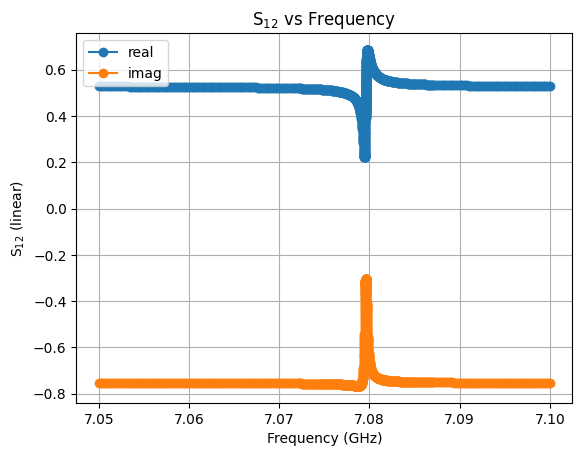

In [ ]:
# plot magnitude in dB
plt.figure()
plt.plot(f,q_array, marker='o',label="real")
plt.plot(f,i_array, marker='o',label="imag")
plt.xlabel('Frequency (GHz)')
plt.ylabel('S$_{12}$ (linear)')
plt.title('S$_{12}$ vs Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from pyCircFit_main import *

In [ ]:
cresults = circlefit(f*1e3, i_array, q_array, \
                     fittype='hanger', plotlabel='test', plot_detail = False, print_results=False, show_plots=False, fitQscl=1, fano = False)
fit_data = S21_hanger(cresults['a'], cresults['alpha'], 0, cresults['fr'], 
                          cresults['Qtot'], cresults['Qc'], cresults['phi'], f*1e3)

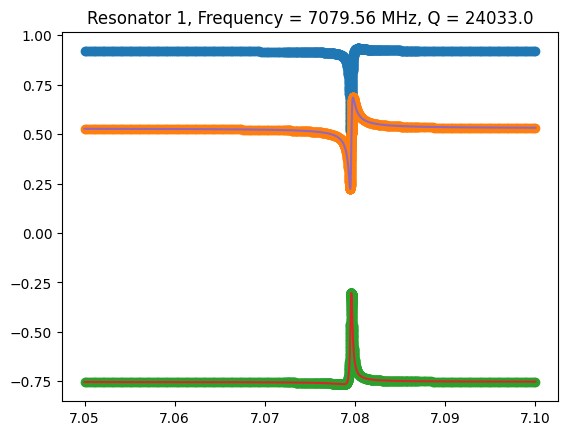

In [ ]:
plt.plot(f, np.abs(i_array*1j+q_array),'o')
plt.plot(f, q_array,'o')
plt.plot(f, i_array,'o')
plt.plot(f, np.real(fit_data))
plt.plot(f, np.imag(fit_data))
plt.title(f'Resonator {1}, Frequency = {np.round(cresults["fr"],2)} MHz, Q = {np.abs(np.round(cresults["Qtot"],1))}')
plt.show()

In [ ]:
cresults

{'xc': np.float64(-0.5346798189084464),
 'xc_stderr': np.float64(2.0338879104911273e-05),
 'yc': np.float64(0.453908201719094),
 'yc_stderr': np.float64(3.6428687478808674e-05),
 'rc': np.float64(0.2309767301430552),
 'rc_stderr': np.float64(1.8834718240593736e-05),
 'theta0': np.float64(5.95224118880279),
 'theta0_stderr': np.float64(0.00034837293002186584),
 'Qtot': np.float64(-24033.020516979115),
 'Qtot_stderr': np.float64(15.43363100887661),
 'fr': np.float64(7079.564243328018),
 'fr_stderr': np.float64(5.42388595977542e-05),
 'alpha': np.float64(2.5292867544255255),
 'alpha_stderr': np.float64(7.879829925359205e-05),
 'a': np.float64(0.9203225475323095),
 'a_stderr': np.float64(5.7542337941754915e-05),
 'phi': np.float64(6.001823526392114),
 'phi_stderr': np.float64(0.000332211746201955),
 'Qc': np.float64(-47879.564866520624),
 'Qc_stderr': np.float64(31.138634835713585),
 'Qi': np.float64(-46414.59836535869),
 'Qi_stderr': np.float64(64.19697744918771)}

In [ ]:
#coupling arm length: 120
gap_list = [12,37,62,87,112]
Qc_list = [5700,23945,68760,157162,326000]

Text(0.5, 1.0, 'Resonator of 4.8GHz, 120um Coupling Arm Length, 35pH/sq KI')

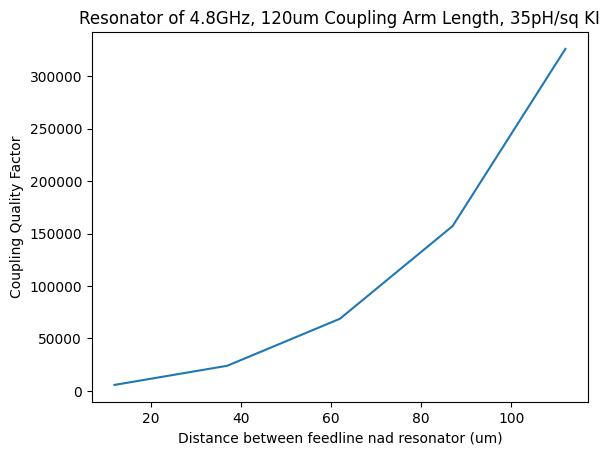

In [ ]:
plt.plot(gap_list,Qc_list)
plt.xlabel('Distance between feedline nad resonator (um)')
plt.ylabel('Coupling Quality Factor')
plt.title('Resonator of 4.8GHz, 120um Coupling Arm Length, 35pH/sq KI')

In [ ]:
gap_list = [30,60,90]
Qc = [2000,14000,24033]

In [ ]:
12.77*250^1.68

TypeError: unsupported operand type(s) for ^: 'float' and 'float'

In [ ]:
import csv
filename = "Qc_Resonator_4.8GHz_120um_Coupling_Arm_Length_35pH_KI_onSi.csv"

with open(filename, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["gap", "Qc"])          # header row
    writer.writerows(zip(gap_list, Qc_list))     # data rows

print(f"Saved → {filename}")

Saved → Qc_Resonator_4.8GHz_120um_Coupling_Arm_Length_35pH_KI_onSi.csv


In [ ]:
#coupling gap width: 37
coupling_arm_list = [12,37,62,87,112]
Qc_list = [5700,23945,68760,157162,326000]